## Assignment 4: Gendered Directions in Embeddings



In [1]:
import numpy as np
from urllib.request import urlopen
from tqdm import tqdm
import os.path
import time

class AlignedEmbeddingLoader(object):
  """This data loader will download an aligned fasttext embedding given a two letter language code.
  More information ca be found at https://fasttext.cc/docs/en/aligned-vectors.html ."""
  def __init__(self, lang='en'):
    """Data loader"""
    self._dataurl = "https://dl.fbaipublicfiles.com/fasttext/vectors-aligned/wiki.%s.align.vec" % lang
    cachefile = "cache_%s.npz" % lang
    if os.path.exists(cachefile):
      print("Loading cached data...", end="")
      t = time.time()
      data = np.load(cachefile)
      self.idx2token_ = list(data['idx2token'])
      self.vectors_ = data['vectors']
      print("done (%isec)" % (time.time()-t), flush=True)
    else:
      with urlopen(self._dataurl) as remote_file:
        get_decoded_line = lambda file: file.readline().decode('utf-8')
        self.n_tokens, self.n_dim = [int(n) for n in get_decoded_line(remote_file).split()]
        self.idx2token_ = list()
        self.vectors_ = np.zeros((self.n_tokens, self.n_dim), dtype=np.float32)
        for n in tqdm(range(self.vectors_.shape[0]), desc="Downloading and parsing vectors"):
          textline = get_decoded_line(remote_file)
          linedata = textline.split(' ')
          self.idx2token_.append(linedata[0])
          self.vectors_[n, :] = np.asarray(linedata[1:], dtype=np.float32)
      np.savez(cachefile, vectors=self.vectors_, idx2token=self.idx2token_)
    self.token2idx_ = {token:i for i, token in enumerate(self.idx2token_)}

loaded_embedding = AlignedEmbeddingLoader('en')

!ls -l

total 5196212
-rw-r--r-- 1 root root 5320910082 Jun  2 21:42 cache_en.npz
drwxr-xr-x 1 root root       4096 Jun  1 13:40 sample_data


## Your analyzer
This is the analyzer. Your task is to finish this in line with the unit tests, the assignment text specifications, and the paper Bolukbasi (2016).

In [2]:
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances
from sklearn.metrics import pairwise_distances

class EmbeddingAnalyzer(object):
  def __init__(self, embedding):
    self.vectors_ = embedding.vectors_
    self.token2idx_ = embedding.token2idx_
    self.idx2token_ = embedding.idx2token_

  def __len__(self):
    """Gives the number of tokens in the embedding."""
    return len(self.vectors_)

  def __getitem__(self, tokens):
    """Returns the vectors for a token or a list of tokens."""
    ind = []
    if type(tokens) == list:
      vec = []
      for tok in tokens:
        try:
          i = self.token2idx_[tok]
          ind.append(i)
        except KeyError:
          continue  
      for idx in ind:
       v = np.array(self.vectors_[idx])
       vec.append(v)
    else:
      vec = self.vectors_[self.token2idx_[tokens]]
      return vec
    return np.array(vec)    

  def __contains__(self, token):
    """Allows a user query if a tokens is in the embedding."""
    try:
      return self.token2idx_[token]
    except KeyError:
      pass

  def projection(self, direction, vectors):
    """The cosine similarity between a reference direction and a matrix of word vectors.    
    direction:
      A vector
    vectors:
      A row matrix with word vectors"""
    res = []
    if vectors.ndim == 1:
     uv = cosine_similarity(direction.reshape(1, -1), vectors.reshape(1, -1))
     return uv
    else:
      for r in vectors:
        uv = cosine_similarity(direction.reshape(1, -1), r.reshape(1, -1))
        res.append(uv)
      return res
     

  def simple_analogy(self, pair, query, k=5):
    """Simple/Classic word analogy as: man - woman = king - queen"""
    v1, v2 = pair[0], pair[1]
    vec = lambda token: np.vstack(self.vectors_[self.token2idx_[token], :]).T
    v = vec(query) - vec(v1) + vec(v2) 
    distances = pairwise_distances(self.vectors_, v, metric='euclidean').ravel()
    res = []
    for idx in np.argsort(distances)[:k]:
      res.append(self.idx2token_[idx])
    return res


  def similarity(self, token1, token2):
    """Returns the cosine similarity between two tokens."""
    token1 = self.__getitem__(token1).reshape(1, -1)
    token2 = self.__getitem__(token2).reshape(1, -1)
    cos_similarity = cosine_similarity(token1, token2)
        
    return cos_similarity[0]

  def analogies(self, analogy_direction, tokens):
    """The more complex word analogy method"""  
    top = []  
    for query in tokens:
      v_query = np.array(self.__getitem__(query)).reshape(1, -1)
      max_cosine_sim = -10000            
      for word in tokens:
        if word in query:
          pass   
        else: 
          v = self.__getitem__(word).reshape(1, -1)    
          if euclidean_distances(v_query - v) <= 1:
            cosine_sim = cosine_similarity((analogy_direction.reshape(1,-1) +v), v_query)
            if cosine_sim > max_cosine_sim:
              max_cosine_sim = cosine_sim
              analogy = word
          else:
            cosine_sim = 0
      top.append((query, analogy))

    return top

analyzer = EmbeddingAnalyzer(loaded_embedding)

assert 'man' in analyzer
assert 'woman' in analyzer
assert 'kdjfsfhgkdsjfdh' not in analyzer

assert len(analyzer) > 100000

assert type(analyzer['man']) is np.ndarray
assert np.isclose(np.sum(analyzer['man']-analyzer['man']), 0)

## Word similarity

We should be able to meassure similarity as cosine similarity.

$cos(\overrightarrow{cat}, \overrightarrow{dog}) \geq cos(\overrightarrow{cat}, \overrightarrow{cow})$

In [3]:
assert analyzer.similarity('cat', 'dog') >= analyzer.similarity('cat', 'cow')

## Word analogies

One of the core tasks for showing any semantic properties in an embedding is finding word analogies. We can this of this as word a is to word b, as word c is to word d. Our task is to find word d, knowing a, b, and c.

$\overrightarrow{a} - \overrightarrow{b} \approx \overrightarrow{c} - \overrightarrow{d}$

For gender, this becomes:

$\overrightarrow{man} - \overrightarrow{woman} \approx \overrightarrow{king} - \overrightarrow{x}$

By rearranging we get:

$\overrightarrow{king} - \overrightarrow{man} + \overrightarrow{woman} \approx \overrightarrow{x}$

In [5]:
best_matches = analyzer.simple_analogy(('man', 'woman'), 'king', k=5)
print("Matches (in order of similarity):")
for i, token in enumerate(best_matches):
  print(i+1, token)

assert 'queen' in analyzer.simple_analogy(('man', 'woman'), 'king', k=5)

Matches (in order of similarity):
1 king
2 queen
3 princess
4 regnant
5 princesses


We can do this for capitols too.

$\overrightarrow{France} - \overrightarrow{Japan} \approx \overrightarrow{Paris} - \overrightarrow{x}$

In [6]:
best_matches = analyzer.simple_analogy(('france', 'japan'), 'paris', k=5)
print("Matches (in order of similarity):")
for i, token in enumerate(best_matches):
  print(i+1, token)

assert 'tokyo' in analyzer.simple_analogy(('france', 'japan'), 'paris', k=5)

Matches (in order of similarity):
1 tokyo
2 japan
3 osaka
4 kyoto
5 tokyo 


In [7]:
best_matches = analyzer.simple_analogy(('old', 'older'), 'big', k=5)
print("Matches (in order of similarity):")
for i, token in enumerate(best_matches):
  print(i+1, token)

Matches (in order of similarity):
1 big
2 bigger
3 older
4 brother/big
5 brother/little


Please try doing this for at least one other famous category (e.g. comparing adjectives).

## Finding the genderedness of professions

Bulokbasi (2016) has a repo for the paper. We can download their data for professions. This allows us to find the genderedness for our embedding and plot against their survey data.

In [8]:
import json
with urlopen('https://raw.githubusercontent.com/tolga-b/debiaswe/master/data/professions.json') as remote_file:
  professions = {title: {'definitional': defi, 'stereotypical': ster} for title, defi, ster in json.load(remote_file)}
print("Loaded %i professions" % len(professions))

Loaded 320 professions


We want to find the projection of vectors for different profession on a gender direction. This can be done by finding the cosine similarity as:

$cos(\overrightarrow{man} - \overrightarrow{woman}, \overrightarrow{butcher})$

$cos(\overrightarrow{man} - \overrightarrow{woman}, \overrightarrow{ballerina})$

The projection should be non-negative as $|cos(\cdot,\cdot)|$. However, by letting the projection method of the anlayzer give us the ccosine similarity, we can see the direction of the projection by looking at its sign.

In [10]:
assert type(analyzer[['man', 'woman', 'butcher']]) is np.ndarray
assert analyzer[['man', 'woman', 'butcher']].shape[0] == 3

assert analyzer.projection(analyzer['man']-analyzer['woman'], analyzer['butcher']) > 0
assert analyzer.projection(analyzer['man']-analyzer['woman'], analyzer['ballerina']) < 0

We create a woman-man direction.

In [12]:
direction = analyzer['man']-analyzer['woman']
titles = [title for title in professions.keys() if title in analyzer]
projection = analyzer.projection(analyzer['man']-analyzer['woman'], analyzer[titles])

The estimation of the gender direction can be improved by using several pairs. Again, we use the data from Bulokbasi (2016).

In [13]:
import json
with urlopen('https://raw.githubusercontent.com/tolga-b/debiaswe/master/data/definitional_pairs.json') as remote_file:
  definitional_pairs = [(m, f) for m, f in json.load(remote_file)]
definitional_pairs

[('woman', 'man'),
 ('girl', 'boy'),
 ('she', 'he'),
 ('mother', 'father'),
 ('daughter', 'son'),
 ('gal', 'guy'),
 ('female', 'male'),
 ('her', 'his'),
 ('herself', 'himself'),
 ('Mary', 'John')]

In [14]:
direction2 = np.zeros(analyzer['man'].shape)
for female, male in definitional_pairs:
  direction2 += analyzer[male.lower()]
  direction2 -= analyzer[female.lower()]

projection2 = analyzer.projection(direction2, analyzer[titles])


We can plot the relation between genderedness in the data and human annotation.

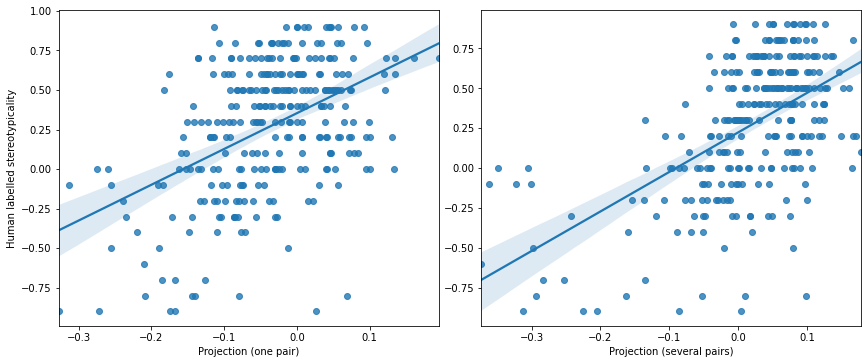

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

fig = plt.figure(figsize=(12, 5))
ax = fig.subplots(1, 2)
stereotypicality = [professions[title]['stereotypical'] for title in titles]
sns.regplot(x=projection, y=stereotypicality, ax=ax[0])
a = sns.regplot(x=projection2, y=stereotypicality, ax=ax[1])
ax[0].set_xlabel("Projection (one pair)")
ax[1].set_xlabel("Projection (several pairs)")
ax[0].set_ylabel("Human labelled stereotypicality")
fig.tight_layout(pad=.5)
fig.show()

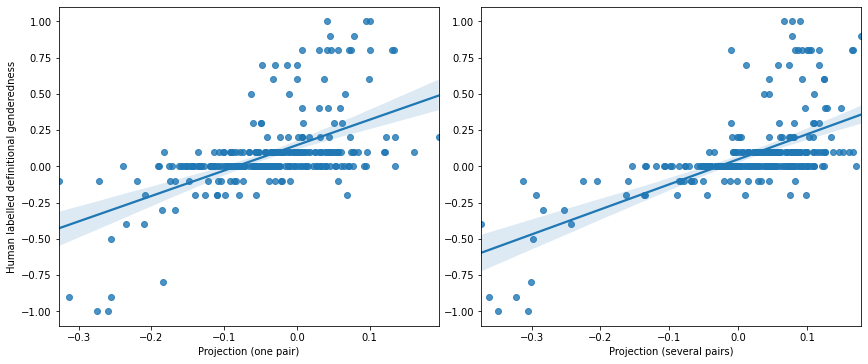

In [16]:
fig = plt.figure(figsize=(12, 5))
ax = fig.subplots(1, 2)
definitionality = [professions[title]['definitional'] for title in titles]
sns.regplot(x=projection, y=definitionality, ax=ax[0])
a = sns.regplot(x=projection2, y=definitionality, ax=ax[1])
ax[0].set_xlabel("Projection (one pair)")
ax[1].set_xlabel("Projection (several pairs)")
ax[0].set_ylabel("Human labelled definitional genderedness")
fig.tight_layout(pad=.5)
fig.show()

## More analogies

The paper defines a more advances procedure for analogies as:

$S_{(a,b)}(x, y) = \left\{\begin{matrix}
cos(\overrightarrow{a}-\overrightarrow{b}, \overrightarrow{x}-\overrightarrow{y}) & \parallel \overrightarrow{x}-\overrightarrow{y} \parallel \leq 1\\ 
0 &  \text{otherwise}
\end{matrix}\right.$

This should return a list of tuples with word pairs.

In [17]:
assert len(analyzer.analogies(analyzer['man']-analyzer['woman'], ['actor', 'actress'])) == 2
assert type(analyzer.analogies(analyzer['man']-analyzer['woman'], ['actor', 'actress'])) == list
assert type(analyzer.analogies(analyzer['man']-analyzer['woman'], ['actor', 'actress'])[0]) == tuple

analyzer.analogies(analyzer['man']-analyzer['woman'], ['actor', 'actress'])

[('actor', 'actress'), ('actress', 'actor')]

In [18]:
analyzer.analogies(analogy_direction=direction2, tokens=titles)

[('accountant', 'bookkeeper'),
 ('acquaintance', 'housekeeper'),
 ('actor', 'actress'),
 ('actress', 'actor'),
 ('administrator', 'bureaucrat'),
 ('adventurer', 'trader'),
 ('advocate', 'campaigner'),
 ('aide', 'officer'),
 ('alderman', 'councilman'),
 ('alter_ego', 'fashion_designer'),
 ('ambassador', 'envoy'),
 ('analyst', 'commentator'),
 ('anthropologist', 'sociologist'),
 ('archaeologist', 'anthropologist'),
 ('archbishop', 'priest'),
 ('architect', 'sculptor'),
 ('artist', 'painter'),
 ('artiste', 'performer'),
 ('assassin', 'hitman'),
 ('astronaut', 'scientist'),
 ('astronomer', 'mathematician'),
 ('athlete', 'swimmer'),
 ('attorney', 'solicitor'),
 ('author', 'writer'),
 ('baker', 'butler'),
 ('ballerina', 'dancer'),
 ('ballplayer', 'infielder'),
 ('banker', 'financier'),
 ('barber', 'hairdresser'),
 ('baron', 'socialite'),
 ('barrister', 'solicitor'),
 ('bartender', 'waitress'),
 ('biologist', 'scientist'),
 ('bishop', 'archbishop'),
 ('bodyguard', 'assassin'),
 ('bookkeeper',